## import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import glob
import os

import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Progress Bar
import statistics
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score,precision_score, recall_score, f1_score

pd.set_option("display.max_rows", None, "display.max_columns", None)

## Read Data

In [3]:
df = pd.read_csv("dataset/Intrusion_detection_NSL_KDD.csv")

print("\n\nSample Data:")
print("============\n")
print(df.head(20))



Sample Data:

    duration protocol_type     service flag  src_bytes  dst_bytes  land   
0          0           udp       other   SF        146          0     0  \
1          0           tcp     private   S0          0          0     0   
2          0           tcp        http   SF        232       8153     0   
3          0           tcp        http   SF        199        420     0   
4          0           tcp     private  REJ          0          0     0   
5          0           tcp     private   S0          0          0     0   
6          0           tcp     private   S0          0          0     0   
7          0           tcp  remote_job   S0          0          0     0   
8          0           tcp     private   S0          0          0     0   
9          0           tcp     private  REJ          0          0     0   
10         0           tcp     private   S0          0          0     0   
11         0           tcp        http   SF        287       2251     0   
12       

## Utils Function

In [4]:
def count_digit(num):
    count = 0
    while num != 0:
        num //= 10
        count += 1
    return count

def check_shape(df):
    rows, cols = df.shape
    print("\nNumber or rows in dataset: {}".format(rows))
    print("==========================={}".format(count_digit(rows)*'='))
    print("\nNumber or columns in dataset: {}".format(cols))
    print("=============================={}".format(count_digit(cols)*'='))
    
def modelEvaluation(predictions, y_test_set, model_name, classes):
    # Print model evaluation to predicted result    
    print("==========",model_name,"==========")
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))    
    print ("\nClassification report : \n", classification_report(y_test_set, predictions, target_names = classes))
#     print ("\nConfusion Matrix : \n", confusion_matrix(y_test_set,predictions))
    sns.heatmap(confusion_matrix(y_test_set, predictions),annot=True,yticklabels=classes, xticklabels=classes, fmt='g',cmap='jet')
    
    plt.title('Confusion Matrix of {}'.format(model_name))
    plt.xlabel('predicted Labels')
    plt.ylabel('Actual Labels')
#     plt.tight_layout()
    plt.show()
    results = [accuracy_score(y_test_set, predictions), precision_score(y_test_set, predictions,average='macro'),
              recall_score(y_test_set, predictions,average='macro'),f1_score(y_test_set, predictions,average='macro')]#store results of model
    return results

# Understand Sample Data
## Dataset Samples and Features Count

In [5]:
# Understand Sample Data

print("\n\nAttributes in Sample Data:")
print("==========================\n")

print(df.columns)

print("\n\nNumber of Instances in Sample Data:",len(df.index))
print("===================================={}\n".format(count_digit(len(df.index))*'='))



Attributes in Sample Data:

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'attack_type'],
      dtype='object')


Number of Instances in Sample Data: 148514



## Initial Class Distribution

attack_type
normal             77052
neptune            45870
satan               4368
ipsweep             3740
smurf               3311
portsweep           3088
nmap                1566
back                1315
guess_passwd        1284
mscan                996
warezmaster          964
teardrop             904
warezclient          890
apache2              737
processtable         685
snmpguess            331
saint                319
mailbomb             293
pod                  242
snmpgetattack        178
httptunnel           133
buffer_overflow       50
land                  25
multihop              25
rootkit               23
named                 17
ps                    15
sendmail              14
xterm                 13
imap                  12
loadmodule            11
ftp_write             11
xlock                  9
phf                    6
perl                   5
xsnoop                 4
spy                    2
worm                   2
sqlattack              2
udpstorm     

<AxesSubplot:xlabel='attack_type'>

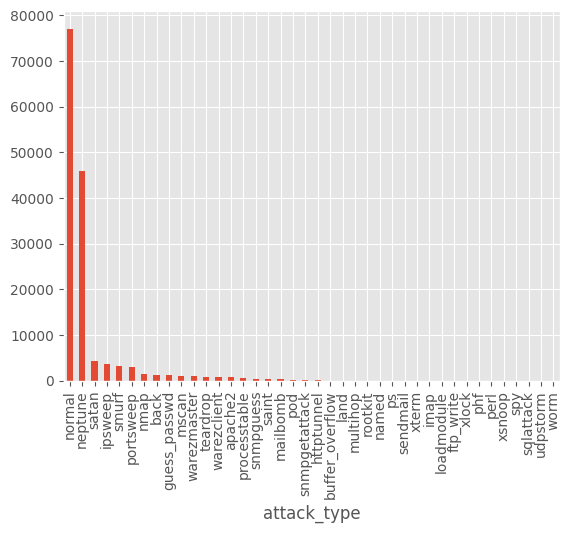

In [6]:
print(df.attack_type.value_counts(), "\n")

plt.style.use('ggplot')
df.value_counts('attack_type').plot(kind='bar')
 

# Preprocessing Data

## Class Mapping to Parent Class

In [7]:
my_dict = dict.fromkeys(['a', 'c', 'd'], 10)
my_dict.update(dict.fromkeys(['b', 'e'], 20))
my_dict

{'a': 10, 'c': 10, 'd': 10, 'b': 20, 'e': 20}

In [8]:
dos_classes = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop']
u2r_classes = ['buffer_overflow', 'loadmodule', 'perl', 'rootkit']
r2l_classes = ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster']
prob_classes = ['ipsweep', 'nmap', 'portsweep', 'satan']

mapping_dict = dict.fromkeys(dos_classes, 'DoS')
mapping_dict.update(dict.fromkeys(u2r_classes, 'U2R'))
mapping_dict.update(dict.fromkeys(r2l_classes, 'R2L'))
mapping_dict.update(dict.fromkeys(prob_classes, 'Prob'))
mapping_dict

{'back': 'DoS',
 'land': 'DoS',
 'neptune': 'DoS',
 'pod': 'DoS',
 'smurf': 'DoS',
 'teardrop': 'DoS',
 'buffer_overflow': 'U2R',
 'loadmodule': 'U2R',
 'perl': 'U2R',
 'rootkit': 'U2R',
 'ftp_write': 'R2L',
 'guess_passwd': 'R2L',
 'imap': 'R2L',
 'multihop': 'R2L',
 'phf': 'R2L',
 'spy': 'R2L',
 'warezclient': 'R2L',
 'warezmaster': 'R2L',
 'ipsweep': 'Prob',
 'nmap': 'Prob',
 'portsweep': 'Prob',
 'satan': 'Prob'}

In [9]:
df['attack_type'].replace(mapping_dict, inplace=True)
df['attack_type'].value_counts()

attack_type
normal           77052
DoS              51667
Prob             12762
R2L               3194
mscan              996
apache2            737
processtable       685
snmpguess          331
saint              319
mailbomb           293
snmpgetattack      178
httptunnel         133
U2R                 89
named               17
ps                  15
sendmail            14
xterm               13
xlock                9
xsnoop               4
worm                 2
sqlattack            2
udpstorm             2
Name: count, dtype: int64

## Drop Unwanted Classes

In [10]:
target_classes = ['normal', 'DoS', 'Prob', 'U2R', 'R2L']
df = df[df['attack_type'].isin(target_classes)]
df['attack_type'].value_counts()

attack_type
normal    77052
DoS       51667
Prob      12762
R2L        3194
U2R          89
Name: count, dtype: int64

Text(0, 0.5, 'Counts')

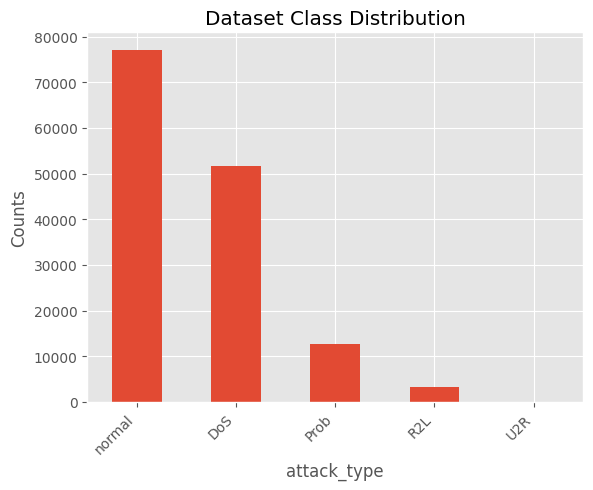

In [11]:
df.shape

plt.style.use('ggplot')
df.value_counts('attack_type').plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Dataset Class Distribution')
plt.ylabel('Counts')

## DownSampling

In [12]:
print(df.shape)
df1 = df[df['attack_type']=='normal'].sample(n=6817)
df2 = df[df['attack_type']=='DoS'].sample(n=11617)
df3 = df[df['attack_type']=='Prob'].sample(n=988)
df4 = df[df['attack_type']=='R2L'].sample(n=53)
df5 = df[df['attack_type']=='U2R'].sample(n=89)

df = pd.concat([df1, df2, df3, df4, df5])
print(df.shape)

(144764, 42)
(19564, 42)


In [13]:
df.attack_type.value_counts()

attack_type
DoS       11617
normal     6817
Prob        988
U2R          89
R2L          53
Name: count, dtype: int64

## Label Encoding

In [14]:
categ = ['protocol_type', 'service', 'flag']

# Encode Categorical Columns
le = LabelEncoder()
df[categ] = df[categ].apply(le.fit_transform)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
64206,0,2,12,9,43,131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,137,0.0,0.0,0.0,0.0,1.0,0.0,0.01,255,253,0.99,0.01,0.00,0.0,0.0,0.0,0.00,0.00,normal
70220,0,1,20,9,1699,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,4,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,102,0.40,0.02,0.40,0.0,0.0,0.0,0.00,0.00,normal
117254,0,1,23,9,172,30881,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,15,15,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,255,1.00,0.00,0.00,0.0,0.0,0.0,0.02,0.02,normal
109863,0,2,12,9,43,131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,236,0.93,0.01,0.00,0.0,0.0,0.0,0.02,0.00,normal
56762,629,2,42,9,145,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,2,0.01,0.62,0.96,0.0,0.0,0.0,0.00,0.00,normal


# Label Encoding

In [15]:
classes = list(df['attack_type'].unique())
print(classes)

le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['attack_type'])
print(list(df['encoded_label'].unique()))
df.head()

['normal', 'DoS', 'Prob', 'R2L', 'U2R']
[4, 0, 1, 2, 3]


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,encoded_label
64206,0,2,12,9,43,131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,137,0.0,0.0,0.0,0.0,1.0,0.0,0.01,255,253,0.99,0.01,0.00,0.0,0.0,0.0,0.00,0.00,normal,4
70220,0,1,20,9,1699,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,4,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,102,0.40,0.02,0.40,0.0,0.0,0.0,0.00,0.00,normal,4
117254,0,1,23,9,172,30881,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,15,15,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,255,1.00,0.00,0.00,0.0,0.0,0.0,0.02,0.02,normal,4
109863,0,2,12,9,43,131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,236,0.93,0.01,0.00,0.0,0.0,0.0,0.02,0.00,normal,4
56762,629,2,42,9,145,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,2,0.01,0.62,0.96,0.0,0.0,0.0,0.00,0.00,normal,4


# Feature Extraction

In [16]:
X = df.iloc[:,1:-2]
y = df['encoded_label']

In [17]:
print(df.shape)
print(X.shape)

(19564, 43)
(19564, 40)


In [18]:
X.head()

,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
64206,2,12,9,43,131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,137,0.0,0.0,0.0,0.0,1.0,0.0,0.01,255,253,0.99,0.01,0.00,0.0,0.0,0.0,0.00,0.00
70220,1,20,9,1699,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,4,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,102,0.40,0.02,0.40,0.0,0.0,0.0,0.00,0.00
117254,1,23,9,172,30881,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,15,15,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,255,1.00,0.00,0.00,0.0,0.0,0.0,0.02,0.02
109863,2,12,9,43,131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,236,0.93,0.01,0.00,0.0,0.0,0.0,0.02,0.00
56762,2,42,9,145,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,2,0.01,0.62,0.96,0.0,0.0,0.0,0.00,0.00


## Min Max Scalling

In [19]:
col = list(X.columns)

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X[col] = scaler.fit_transform(X[col])
X.head()

,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
64206,1.0,0.181818,0.9,0.000008,0.000069,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.176125,0.268102,0.0,0.0,0.0,0.0,1.0,0.0,0.01,1.0,0.992157,0.99,0.01,0.00,0.0,0.0,0.0,0.00,0.00
70220,0.5,0.303030,0.9,0.000300,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007828,0.007828,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.0,0.400000,0.40,0.02,0.40,0.0,0.0,0.0,0.00,0.00
117254,0.5,0.348485,0.9,0.000030,0.016203,0.0,0.0,0.0,0.022727,0.0,1.0,0.001466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029354,0.029354,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.0,1.000000,1.00,0.00,0.00,0.0,0.0,0.0,0.02,0.02
109863,1.0,0.181818,0.9,0.000008,0.000069,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.0,0.925490,0.93,0.01,0.00,0.0,0.0,0.0,0.02,0.00
56762,1.0,0.636364,0.9,0.000026,0.000055,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.0,0.007843,0.01,0.62,0.96,0.0,0.0,0.0,0.00,0.00


# Train Test Split

In [21]:
def split_df(X, y, split_index):
    if split_index==0:
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
        return X_train,X_test,y_train,y_test
    if split_index==1:
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
        X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.1)
        return X_train, X_test, X_val, y_train, y_test, y_val

In [22]:
split_index = 0
split = ['train_test', 'train_test_val']

# y = df['encoded_label']
X_train,X_test,y_train,y_test = split_df(X, y, split_index)

In [23]:
print(X_train.shape)
print(X_test.shape)

(13694, 40)
(5870, 40)


encoded_label
0    8118
4    4789
1     686
3      65
2      36
Name: count, dtype: int64 



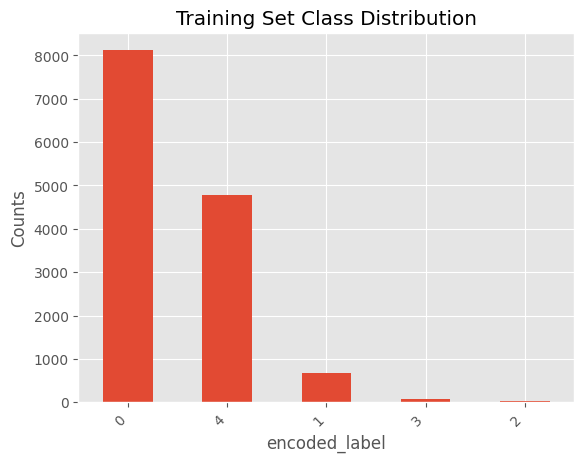

encoded_label
0    3499
4    2028
1     302
3      24
2      17
Name: count, dtype: int64 



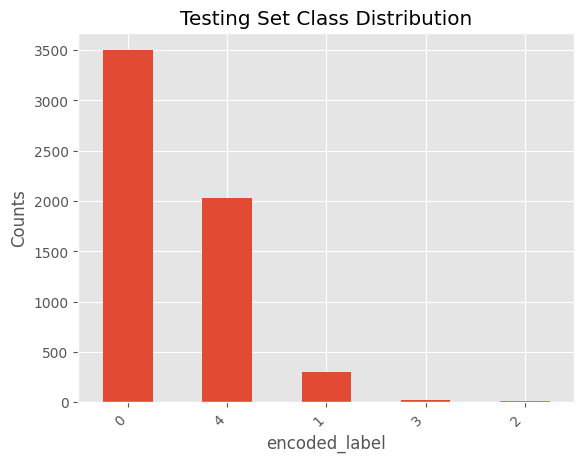

In [24]:
X_train1,X_test1,y_train1,y_test1 = split_df(X, y, split_index)

print(y_train1.value_counts(), "\n")
plt.style.use('ggplot')
y_train1.value_counts().plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Training Set Class Distribution')
plt.ylabel('Counts')
plt.show()

print(y_test1.value_counts(), "\n")
plt.style.use('ggplot')
y_test1.value_counts().plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Testing Set Class Distribution')
plt.ylabel('Counts')
plt.show()

# print(y_val1.value_counts(), "\n")
# plt.style.use('ggplot')
# y_val1.value_counts().plot(kind='bar')
# plt.xticks(rotation=45, horizontalalignment='right')
# plt.title('Validation Set Class Distribution')
# plt.ylabel('Counts')

del X_train1,X_test1,y_train1,y_test1

# Machine Learning

In [25]:
classes = list(df.attack_type.unique())
collect_results_of_all_model= {
    'Metrics':['accuracy','precision','recall','f1-score']
} #dic form store results of all models

## Linear SVM Model

In [120]:
from sklearn.svm import SVC

SVC_classifier = SVC(kernel='linear')
SVC_classifier.fit(X_train,y_train)

preds = SVC_classifier.predict(X_test)

## SVM Results

========== Linear SVM ==========

Accuracy on validation set: 0.9647

Classification report : 
               precision    recall  f1-score   support

      normal       0.99      0.98      0.98      3501
         DoS       0.90      0.86      0.88       302
        Prob       1.00      0.08      0.15        12
         R2L       0.91      0.42      0.57        24
         U2R       0.93      0.97      0.95      2031

    accuracy                           0.96      5870
   macro avg       0.95      0.66      0.71      5870
weighted avg       0.97      0.96      0.96      5870



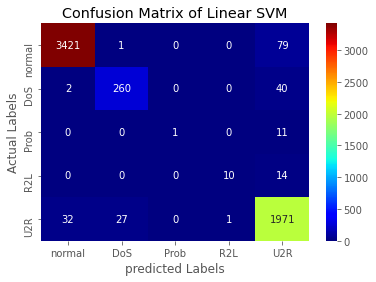

In [121]:
SVC_res=modelEvaluation(preds, y_test, 'Linear SVM', classes)
collect_results_of_all_model["Linear SVM"] = SVC_res

## Quadratic SVM

In [122]:
from sklearn.svm import SVC

SVC_classifier = SVC(kernel='poly', degree=2)
SVC_classifier.fit(X_train,y_train)

preds = SVC_classifier.predict(X_test)

## Reuslt

========== Quad SVM ==========

Accuracy on validation set: 0.9751

Classification report : 
               precision    recall  f1-score   support

      normal       0.99      0.98      0.99      3501
         DoS       0.97      0.92      0.94       302
        Prob       0.00      0.00      0.00        12
         R2L       0.91      0.42      0.57        24
         U2R       0.95      0.99      0.97      2031

    accuracy                           0.98      5870
   macro avg       0.76      0.66      0.69      5870
weighted avg       0.97      0.98      0.97      5870



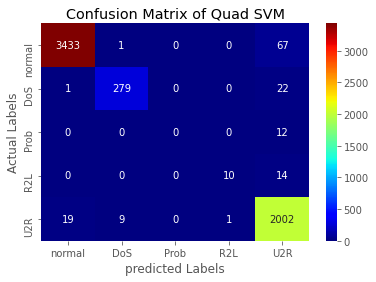

In [123]:
SVC_res=modelEvaluation(preds, y_test, 'Quad SVM', classes)
collect_results_of_all_model["Quad SVM"] = SVC_res

## Cubic SVM

In [124]:
from sklearn.svm import SVC

SVC_classifier = SVC(kernel='poly', degree=3)
SVC_classifier.fit(X_train,y_train)

preds = SVC_classifier.predict(X_test)

## Results

========== Cubic SVM ==========

Accuracy on validation set: 0.9780

Classification report : 
               precision    recall  f1-score   support

      normal       0.99      0.98      0.99      3501
         DoS       0.97      0.94      0.95       302
        Prob       0.50      0.08      0.14        12
         R2L       0.90      0.38      0.53        24
         U2R       0.95      0.99      0.97      2031

    accuracy                           0.98      5870
   macro avg       0.86      0.67      0.72      5870
weighted avg       0.98      0.98      0.98      5870



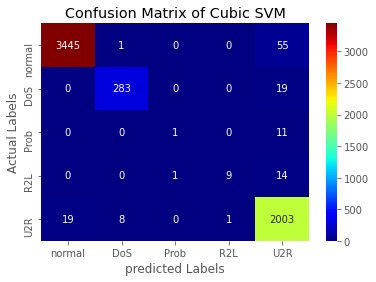

In [125]:
SVC_res=modelEvaluation(preds, y_test, 'Cubic SVM', classes)
collect_results_of_all_model["Cubic SVM"] = SVC_res

## Fine KNN Model

In [126]:
from sklearn.neighbors import KNeighborsClassifier

neighbors_clf = KNeighborsClassifier(n_neighbors=1)
neighbors_clf.fit(X_train,y_train)

KNN_preds = neighbors_clf.predict(X_test)

## KNN Results

========== Fine KNN ==========

Accuracy on validation set: 0.9889

Classification report : 
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00      3501
         DoS       0.96      0.96      0.96       302
        Prob       0.73      0.67      0.70        12
         R2L       0.69      0.75      0.72        24
         U2R       0.99      0.98      0.99      2031

    accuracy                           0.99      5870
   macro avg       0.87      0.87      0.87      5870
weighted avg       0.99      0.99      0.99      5870



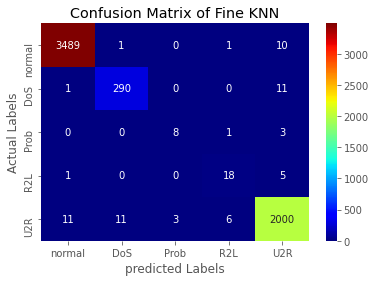

In [127]:
KNN_res = modelEvaluation(KNN_preds,y_test,'Fine KNN',classes)
collect_results_of_all_model["Fine KNN"] = KNN_res

## Medium KNN

In [128]:
from sklearn.neighbors import KNeighborsClassifier

neighbors_clf = KNeighborsClassifier(n_neighbors=10)
neighbors_clf.fit(X_train,y_train)

KNN_preds = neighbors_clf.predict(X_test)

## Results

========== Medium KNN ==========

Accuracy on validation set: 0.9801

Classification report : 
               precision    recall  f1-score   support

      normal       0.99      1.00      0.99      3501
         DoS       0.91      0.94      0.92       302
        Prob       0.20      0.08      0.12        12
         R2L       0.91      0.42      0.57        24
         U2R       0.98      0.97      0.97      2031

    accuracy                           0.98      5870
   macro avg       0.80      0.68      0.72      5870
weighted avg       0.98      0.98      0.98      5870



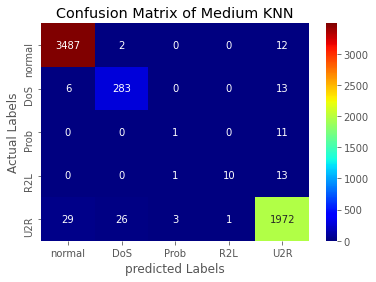

In [129]:
KNN_res = modelEvaluation(KNN_preds,y_test,'Medium KNN',classes)
collect_results_of_all_model["Medium KNN"] = KNN_res

## Cubic KNN

In [130]:
from sklearn.neighbors import KNeighborsClassifier

neighbors_clf = KNeighborsClassifier(n_neighbors=10, metric='cosine')
neighbors_clf.fit(X_train,y_train)

KNN_preds = neighbors_clf.predict(X_test)

========== Cubic KNN ==========

Accuracy on validation set: 0.9811

Classification report : 
               precision    recall  f1-score   support

      normal       0.99      1.00      0.99      3501
         DoS       0.91      0.94      0.93       302
        Prob       0.33      0.08      0.13        12
         R2L       0.91      0.42      0.57        24
         U2R       0.98      0.97      0.97      2031

    accuracy                           0.98      5870
   macro avg       0.82      0.68      0.72      5870
weighted avg       0.98      0.98      0.98      5870



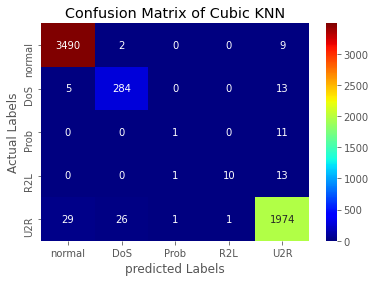

In [131]:
KNN_res = modelEvaluation(KNN_preds,y_test,'Cubic KNN',classes)
collect_results_of_all_model["Cubic KNN"] = KNN_res

## Fine Decision Tree

In [132]:
from sklearn.tree import DecisionTreeClassifier

DT_classifier = DecisionTreeClassifier(max_leaf_nodes= 100)
DT_classifier.fit(X_train,y_train)

preds = DT_classifier.predict(X_test)

## Results

========== Fine DT ==========

Accuracy on validation set: 0.9882

Classification report : 
               precision    recall  f1-score   support

      normal       0.99      1.00      1.00      3501
         DoS       0.95      0.98      0.96       302
        Prob       0.86      0.50      0.63        12
         R2L       0.88      0.58      0.70        24
         U2R       0.99      0.98      0.98      2031

    accuracy                           0.99      5870
   macro avg       0.93      0.81      0.85      5870
weighted avg       0.99      0.99      0.99      5870



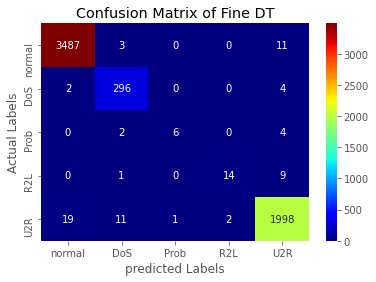

In [133]:
DT_res=modelEvaluation(preds, y_test, 'Fine DT', classes)
collect_results_of_all_model["Fine DT"] = DT_res

## Medium DT

In [134]:
DT_classifier = DecisionTreeClassifier(max_leaf_nodes= 20)
DT_classifier.fit(X_train,y_train)

preds = DT_classifier.predict(X_test)

## Results

========== Medium DT ==========

Accuracy on validation set: 0.9816

Classification report : 
               precision    recall  f1-score   support

      normal       0.99      1.00      0.99      3501
         DoS       0.93      0.93      0.93       302
        Prob       0.00      0.00      0.00        12
         R2L       0.83      0.42      0.56        24
         U2R       0.98      0.98      0.98      2031

    accuracy                           0.98      5870
   macro avg       0.75      0.66      0.69      5870
weighted avg       0.98      0.98      0.98      5870



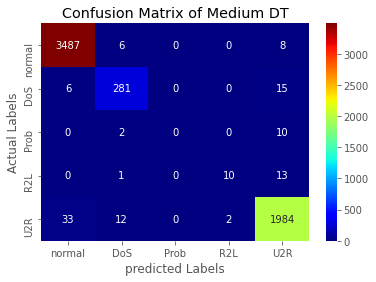

In [135]:
DT_res=modelEvaluation(preds, y_test, 'Medium DT', classes)
collect_results_of_all_model["Medium DT"] = DT_res

## Proposed Model

In [136]:
from sklearn.ensemble import VotingClassifier

clf1 = DecisionTreeClassifier(max_leaf_nodes= 100)
clf2 = KNeighborsClassifier(n_neighbors=10)
clf3 = KNeighborsClassifier(n_neighbors=1)

voting_classifier = VotingClassifier(estimators=[('DT', clf1), ('KNN1', clf2), ('KNN2', clf3)], voting='hard')
voting_classifier.fit(X_train, y_train)

preds = voting_classifier.predict(X_test)

========== Voting ==========

Accuracy on validation set: 0.9896

Classification report : 
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00      3501
         DoS       0.95      0.97      0.96       302
        Prob       0.86      0.50      0.63        12
         R2L       0.93      0.54      0.68        24
         U2R       0.99      0.99      0.99      2031

    accuracy                           0.99      5870
   macro avg       0.94      0.80      0.85      5870
weighted avg       0.99      0.99      0.99      5870



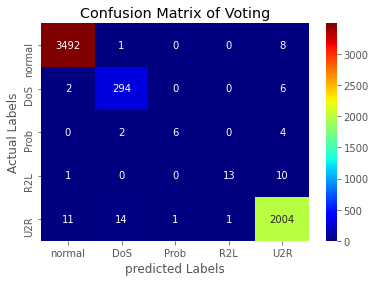

In [137]:
voting_res=modelEvaluation(preds, y_test, 'Voting', classes)
collect_results_of_all_model["Voting"] = voting_res

# Rsults Comparison
## Comparison Table

In [138]:
from tabulate import tabulate 
metrics_data_frame = pd.DataFrame(collect_results_of_all_model) # create dataframe
metrics_data_frame = metrics_data_frame.set_index('Metrics') # set index
# displaying the DataFrame
print(tabulate(metrics_data_frame, headers = 'keys', tablefmt = 'psql')) # convert results in to table

+-----------+--------------+------------+-------------+------------+--------------+-------------+-----------+-------------+----------+
| Metrics   |   Linear SVM |   Quad SVM |   Cubic SVM |   Fine KNN |   Medium KNN |   Cubic KNN |   Fine DT |   Medium DT |   Voting |
|-----------+--------------+------------+-------------+------------+--------------+-------------+-----------+-------------+----------|
| accuracy  |     0.964736 |   0.975128 |    0.978024 |   0.988927 |     0.980068 |    0.98109  |  0.988245 |    0.981601 | 0.989608 |
| precision |     0.946789 |   0.762875 |    0.863319 |   0.872368 |     0.796975 |    0.824052 |  0.931605 |    0.746015 | 0.942656 |
| recall    |     0.661707 |   0.661361 |    0.673128 |   0.871648 |     0.680808 |    0.681838 |  0.808644 |    0.663998 | 0.799862 |
| f1-score  |     0.708208 |   0.693644 |    0.716727 |   0.871514 |     0.715755 |    0.719602 |  0.85483  |    0.691115 | 0.851637 |
+-----------+--------------+------------+-------------+

In [139]:
metrics_data_frame

,Linear SVM,Quad SVM,Cubic SVM,Fine KNN,Medium KNN,Cubic KNN,Fine DT,Medium DT,Voting
Metrics,,,,,,,,,
accuracy,0.964736,0.975128,0.978024,0.988927,0.980068,0.981090,0.988245,0.981601,0.989608
precision,0.946789,0.762875,0.863319,0.872368,0.796975,0.824052,0.931605,0.746015,0.942656
recall,0.661707,0.661361,0.673128,0.871648,0.680808,0.681838,0.808644,0.663998,0.799862
f1-score,0.708208,0.693644,0.716727,0.871514,0.715755,0.719602,0.854830,0.691115,0.851637


Text(0.5, 0, 'Evaluation Measure')

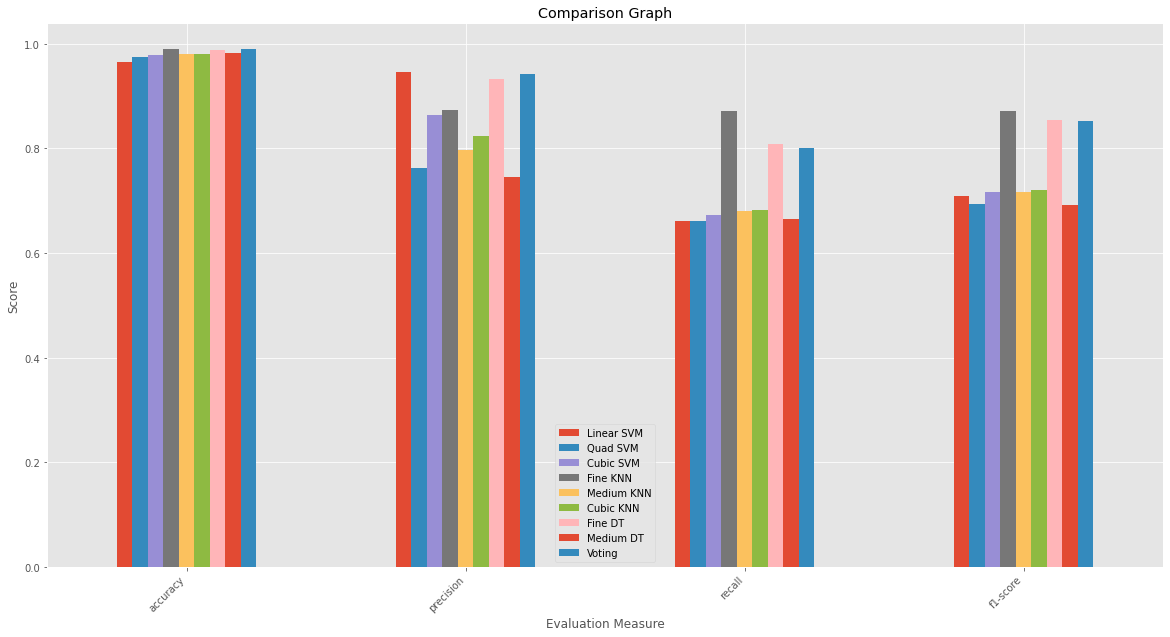

In [140]:
metrics_data_frame.plot(kind='bar', figsize=(20,10)) # sho comparison base of mertics
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Comparison Graph')
plt.ylabel('Score')
plt.xlabel("Evaluation Measure")